In [52]:
%pip install optuna
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install keras
%pip install scikit-learn
%pip install tensorflow

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
import os
print(os.getcwd())
df = pd.read_csv('data-bitcoin_timedata_v2.csv')

df.head()
df.info()

/content
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


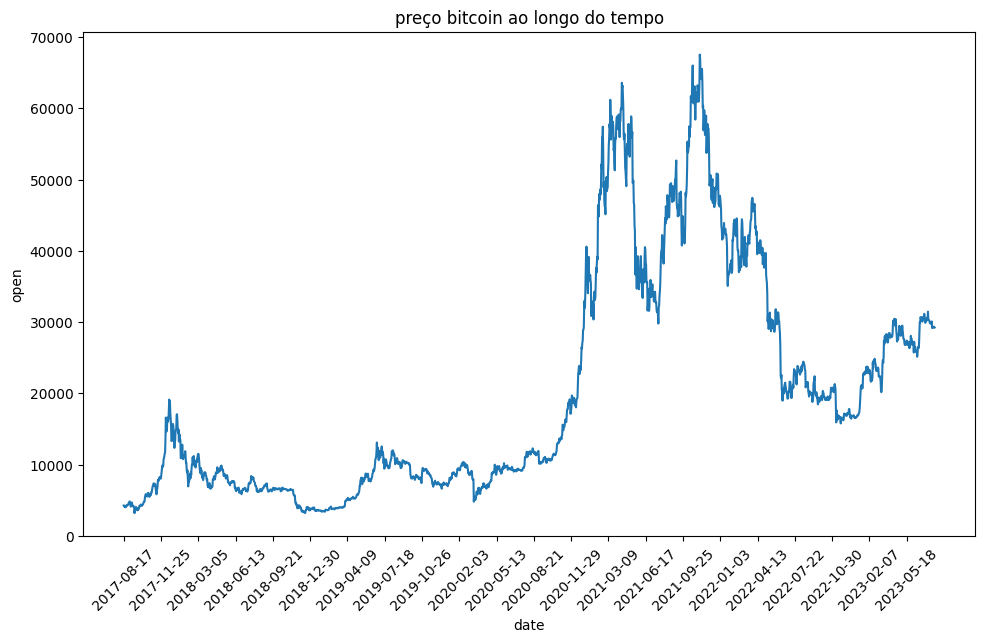

In [55]:
# Gráfico de Linhas para Preços de Abertura ao longo do tempo
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='open', data=df)
plt.title('preço bitcoin ao longo do tempo')
plt.tight_layout()
plt.xticks(df['date'][::100], rotation=45)
plt.show()

In [56]:
# Train-Test Split (80-20)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Split temporal: treino->validação->teste
train_size = int(0.8 * len(df))
test_size = len(df) - train_size

# Separar dados mantendo ordem temporal
train_data = df[:train_size]
test_data = df[train_size:]

# Fit scaler APENAS nos dados de treino
scaler = StandardScaler()
scaler.fit(train_data['close'].values.reshape(-1, 1))

# Transform separadamente
train_scaled = scaler.transform(train_data['close'].values.reshape(-1, 1))
test_scaled = scaler.transform(test_data['close'].values.reshape(-1, 1))

# Criar sequências
sequence_length = 30
def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [57]:
# 2. Model Definition and Compilation
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define model
model = Sequential([
    LSTM(10, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(10),
    Dropout(0.2),
    Dense(1)
])

# Compile model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 30, 10)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Model Training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=9,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 0.2646 - val_loss: 0.1059
Epoch 2/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0375 - val_loss: 0.0872
Epoch 3/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0405 - val_loss: 0.0699
Epoch 4/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0340 - val_loss: 0.0453
Epoch 5/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0293 - val_loss: 0.0434
Epoch 6/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0284 - val_loss: 0.0465
Epoch 7/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0298 - val_loss: 0.0269
Epoch 8/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0249 - val_loss: 0.0227
Epoch 9/9
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0283 - val_loss: 0.0304


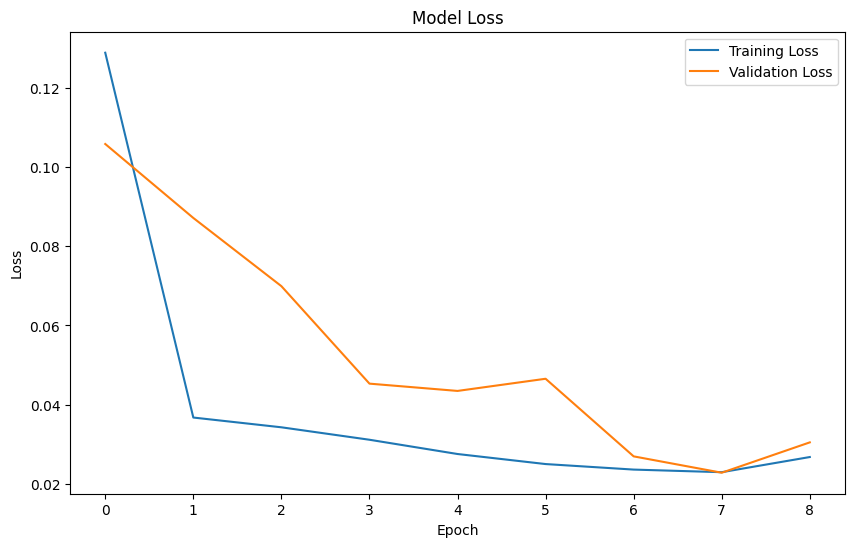

In [59]:
# Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


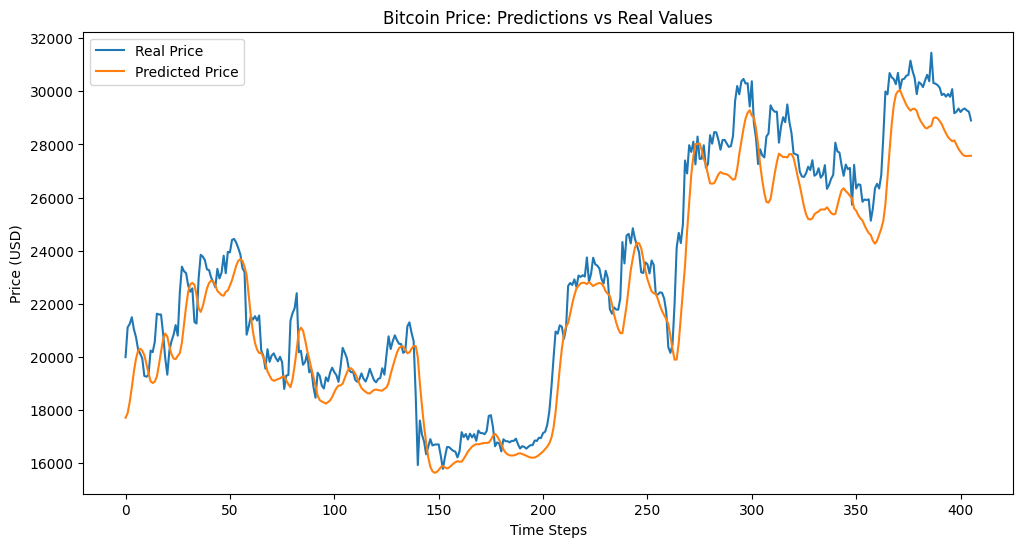

Root Mean Square Error: 0.0743
Mean Absolute Error: 0.0586
R² Score: 0.9120


In [60]:
# Make Predictions
predictions = model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test), label='Real Price')
plt.plot(scaler.inverse_transform(predictions), label='Predicted Price')
plt.title('Bitcoin Price: Predictions vs Real Values')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Square Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


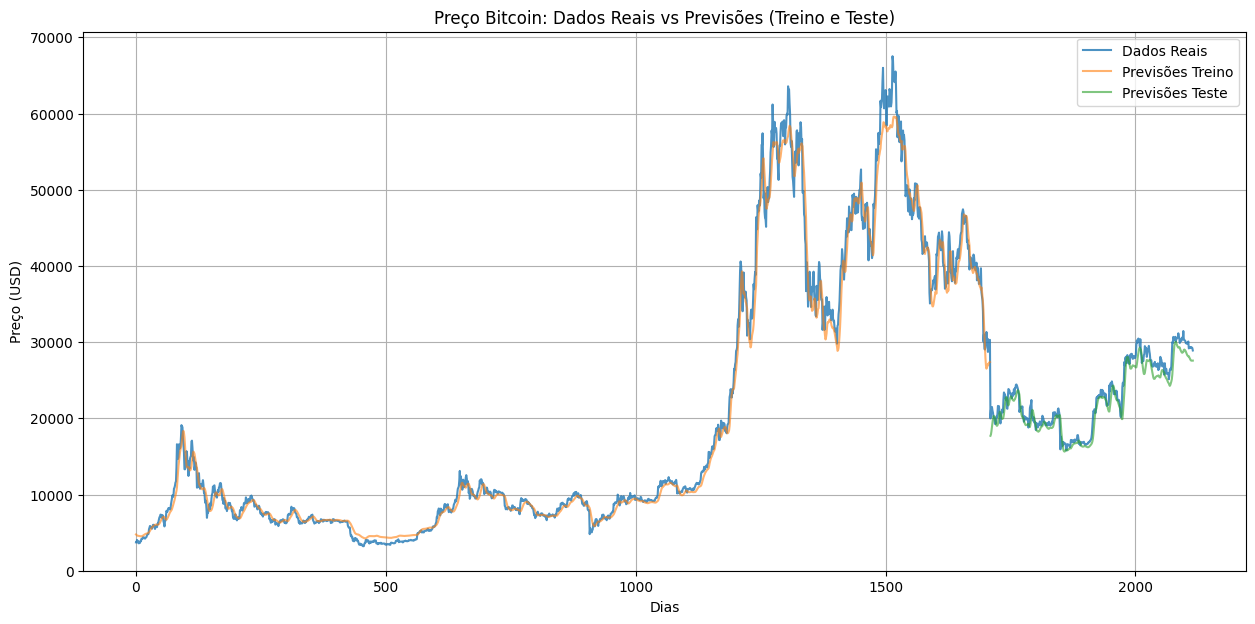

In [61]:
# Fazer previsões tanto no conjunto de treino quanto teste
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Criar arrays para plotagem
# Dados reais completos
real_prices = np.concatenate([
    scaler.inverse_transform(y_train),
    scaler.inverse_transform(y_test)
])

# Previsões (None para dados não previstos)
train_plot = np.concatenate([
    scaler.inverse_transform(train_predictions),
    np.array([[None]] * len(y_test))
])

test_plot = np.concatenate([
    np.array([[None]] * len(y_train)),
    scaler.inverse_transform(test_predictions)
])

# Plotar
plt.figure(figsize=(15, 7))
plt.plot(real_prices, label='Dados Reais', alpha=0.8)
plt.plot(train_plot, label='Previsões Treino', alpha=0.6)
plt.plot(test_plot, label='Previsões Teste', alpha=0.6)
plt.title('Preço Bitcoin: Dados Reais vs Previsões (Treino e Teste)')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 4. AVALIAÇÃO ADICIONAL: ACURÁCIA DIRECIONAL (POCID) ###


In [62]:


print("--- Calculando Acurácia Direcional (POCID) ---")

# 1. Desnormalizar os dados reais e as previsões do conjunto de teste
# Isso é crucial para comparar as mudanças de preço em USD
real_prices_test = scaler.inverse_transform(y_test)
predicted_prices_test = scaler.inverse_transform(test_predictions)

# 2. Calcular as diferenças diárias (mudança de um dia para o outro)
# Usamos .flatten() para garantir que são arrays 1D
real_diff = np.diff(real_prices_test.flatten())
pred_diff = np.diff(predicted_prices_test.flatten())

# 3. Verificar se as direções (sinais) são as mesmas
# A "mágica" está aqui: (real_diff * pred_diff) > 0
#
# Se ambos forem positivos (subida), (pos * pos) > 0 => True (Acerto)
# Se ambos forem negativos (queda), (neg * neg) > 0 => True (Acerto)
# Se os sinais forem opostos, (pos * neg) < 0   => False (Erro)
#
# Nota: Isso ignora dias com mudança zero (real_diff ou pred_diff == 0),
# que é o comportamento padrão e desejado para o POCID.

correct_directions = (real_diff * pred_diff) > 0

# 4. Calcular a porcentagem de acertos
# Usamos np.mean(True/False array) como uma forma rápida de calcular a porcentagem
pocid = np.mean(correct_directions) * 100

print(f"Total de previsões no conjunto de teste: {len(predicted_prices_test)} dias.")
print(f"Total de comparações direcionais: {len(correct_directions)} (N-1 dias).")
print(f"\n📈 Acurácia Direcional (POCID): {pocid:.2f}%")

print("--------------------------------------------------")
if pocid > 50:
    print(f"O modelo acertou a direção do preço em {pocid:.2f}% das vezes,")
    print("o que é melhor do que um palpite aleatório (50%).")
else:
    print(f"O modelo acertou a direção em {pocid:.2f}% das vezes.")
    print("Isso não é melhor do que um palpite aleatório (50%).")
print("--------------------------------------------------")

--- Calculando Acurácia Direcional (POCID) ---
Total de previsões no conjunto de teste: 406 dias.
Total de comparações direcionais: 405 (N-1 dias).

📈 Acurácia Direcional (POCID): 43.46%
--------------------------------------------------
O modelo acertou a direção em 43.46% das vezes.
Isso não é melhor do que um palpite aleatório (50%).
--------------------------------------------------


# Task
Improve the performance of the POCID model.

## Experiment with lstm architecture

### Subtask:
Modify the existing model by adding more LSTM layers, changing the number of units in each layer, or incorporating Bidirectional LSTM layers to capture dependencies in both forward and backward directions.


**Reasoning**:
Define a new Keras Sequential model, add Bidirectional and standard LSTM layers with Dropout, a final Dense layer, compile the model, and print its summary.



In [63]:
# Define a new Keras Sequential model
model = Sequential([
    # Add a Bidirectional LSTM layer
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, 1)),
    # Add a Dropout layer
    Dropout(0.3),
    # Add another LSTM layer
    LSTM(50, return_sequences=False),
    # Add a Dropout layer
    Dropout(0.3),
    # Add a final Dense layer
    Dense(1)
])

# Compile the new model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Print the summary of the new model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 30, 100)        │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

## Hyperparameter tuning with optuna

### Subtask:
Use Optuna to optimize hyperparameters such as the learning rate, number of LSTM units, dropout rates, and sequence length to find the best combination for improved POCID.


**Reasoning**:
Define the objective function for Optuna to optimize the hyperparameters of the LSTM model for POCID, including the model building, training, prediction, and POCID calculation steps within the function.



In [64]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    # Hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    lstm_units_1 = trial.suggest_int('lstm_units_1', 10, 100)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 10, 100)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.1, 0.5)
    dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.1, 0.5)
    sequence_length = trial.suggest_int('sequence_length', 10, 60)

    # Re-create sequences with the suggested sequence length
    def create_sequences_trial(data, seq_len):
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data[i:(i + seq_len)])
            y.append(data[i + seq_len])
        return np.array(X), np.array(y)

    # Use a validation split within the training data for hyperparameter tuning
    X_train_trial, X_val, y_train_trial, y_val = train_test_split(
        X_train, y_train, test_size=0.2, shuffle=False
    )

    # Build the model with suggested hyperparameters
    model = Sequential([
        LSTM(lstm_units_1, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(dropout_rate_1),
        LSTM(lstm_units_2),
        Dropout(dropout_rate_2),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Define early stopping with a smaller patience for faster trials
    early_stopping_trial = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_trial, y_train_trial,
        validation_data=(X_val, y_val),
        epochs=50, # Set a higher number of epochs and rely on early stopping
        batch_size=32,
        callbacks=[early_stopping_trial],
        verbose=0 # Suppress training output for cleaner Optuna logs
    )

    # Make predictions on the validation set
    val_predictions = model.predict(X_val)

    # Calculate POCID on the validation set
    # Inverse transform y_val and val_predictions
    y_val_original = scaler.inverse_transform(y_val)
    val_predictions_original = scaler.inverse_transform(val_predictions)

    # Calculate directional accuracy (POCID)
    real_diff_val = np.diff(y_val_original.flatten())
    pred_diff_val = np.diff(val_predictions_original.flatten())
    correct_directions_val = (real_diff_val * pred_diff_val) > 0

    # Handle cases where correct_directions_val is empty (e.g., due to small validation set)
    if len(correct_directions_val) == 0:
        pocid_val = 0.0
    else:
        pocid_val = np.mean(correct_directions_val) * 100

    # Optuna aims to minimize the objective function, so we return negative POCID
    # Or, return validation loss if POCID is not a good direct optimization metric
    # For this task, let's try minimizing validation loss first as POCID can be noisy
    return history.history['val_loss'][-1]

# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) # Run 20 trials

# Print the best hyperparameters and objective value
print("Best hyperparameters: ", study.best_params)
print("Best objective value (validation loss): ", study.best_value)

[I 2025-11-07 06:22:03,185] A new study created in memory with name: no-name-7bc5013b-8bac-4c6e-9091-496202d27b28
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


[I 2025-11-07 06:22:59,107] Trial 0 finished with value: 0.02206878550350666 and parameters: {'learning_rate': 0.001286837576885224, 'lstm_units_1': 89, 'lstm_units_2': 53, 'dropout_rate_1': 0.26924240271005717, 'dropout_rate_2': 0.1837194011513984, 'sequence_length': 57}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-11-07 06:23:30,184] Trial 1 finished with value: 0.08649687469005585 and parameters: {'learning_rate': 3.1998765411163095e-05, 'lstm_units_1': 33, 'lstm_units_2': 74, 'dropout_rate_1': 0.4449508722056916, 'dropout_rate_2': 0.28004732279358535, 'sequence_length': 41}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2025-11-07 06:23:53,174] Trial 2 finished with value: 0.03855917230248451 and parameters: {'learning_rate': 0.00420053334821504, 'lstm_units_1': 13, 'lstm_units_2': 35, 'dropout_rate_1': 0.27689282589634556, 'dropout_rate_2': 0.20497751650991627, 'sequence_length': 46}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-11-07 06:25:05,167] Trial 3 finished with value: 0.03342418000102043 and parameters: {'learning_rate': 0.00012040693967534964, 'lstm_units_1': 97, 'lstm_units_2': 40, 'dropout_rate_1': 0.4146888604507929, 'dropout_rate_2': 0.192847189543431, 'sequence_length': 10}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:26:26,290] Trial 4 finished with value: 0.023108430206775665 and parameters: {'learning_rate': 0.00038100425584138963, 'lstm_units_1': 55, 'lstm_units_2': 66, 'dropout_rate_1': 0.2839817468877177, 'dropout_rate_2': 0.30211428107653693, 'sequence_length': 52}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


[I 2025-11-07 06:27:26,490] Trial 5 finished with value: 0.023910051211714745 and parameters: {'learning_rate': 0.00043448023607005885, 'lstm_units_1': 19, 'lstm_units_2': 58, 'dropout_rate_1': 0.2526986969284145, 'dropout_rate_2': 0.4158666974299542, 'sequence_length': 54}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


[I 2025-11-07 06:28:41,010] Trial 6 finished with value: 0.025032835081219673 and parameters: {'learning_rate': 0.0007942329245407136, 'lstm_units_1': 34, 'lstm_units_2': 61, 'dropout_rate_1': 0.2444825651392485, 'dropout_rate_2': 0.4409101473747956, 'sequence_length': 13}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:29:40,913] Trial 7 finished with value: 0.05848757550120354 and parameters: {'learning_rate': 0.0005758014472470211, 'lstm_units_1': 97, 'lstm_units_2': 14, 'dropout_rate_1': 0.259582810664845, 'dropout_rate_2': 0.41053663152827213, 'sequence_length': 19}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-11-07 06:31:17,077] Trial 8 finished with value: 0.09592605382204056 and parameters: {'learning_rate': 1.9748278488978844e-05, 'lstm_units_1': 87, 'lstm_units_2': 11, 'dropout_rate_1': 0.1052332560732622, 'dropout_rate_2': 0.4051748358557099, 'sequence_length': 10}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


[I 2025-11-07 06:32:31,195] Trial 9 finished with value: 0.03855105862021446 and parameters: {'learning_rate': 6.544308786869087e-05, 'lstm_units_1': 51, 'lstm_units_2': 32, 'dropout_rate_1': 0.1015680237904137, 'dropout_rate_2': 0.29634994318076374, 'sequence_length': 28}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:32:59,816] Trial 10 finished with value: 0.023718010634183884 and parameters: {'learning_rate': 0.008307045516402108, 'lstm_units_1': 74, 'lstm_units_2': 96, 'dropout_rate_1': 0.36175645990835686, 'dropout_rate_2': 0.10947504973208941, 'sequence_length': 60}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


[I 2025-11-07 06:33:22,628] Trial 11 finished with value: 0.0481317974627018 and parameters: {'learning_rate': 0.0018756336546599864, 'lstm_units_1': 65, 'lstm_units_2': 81, 'dropout_rate_1': 0.3442994139178843, 'dropout_rate_2': 0.206188937650111, 'sequence_length': 51}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-11-07 06:34:41,496] Trial 12 finished with value: 0.028665531426668167 and parameters: {'learning_rate': 0.00016406082083208307, 'lstm_units_1': 53, 'lstm_units_2': 69, 'dropout_rate_1': 0.1772919109905771, 'dropout_rate_2': 0.335622867721412, 'sequence_length': 35}. Best is trial 0 with value: 0.02206878550350666.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-11-07 06:35:16,509] Trial 13 finished with value: 0.019926661625504494 and parameters: {'learning_rate': 0.001587241800386554, 'lstm_units_1': 76, 'lstm_units_2': 45, 'dropout_rate_1': 0.49910960935961396, 'dropout_rate_2': 0.10819960852190533, 'sequence_length': 60}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:36:25,668] Trial 14 finished with value: 0.022145530208945274 and parameters: {'learning_rate': 0.0013925431457834485, 'lstm_units_1': 77, 'lstm_units_2': 43, 'dropout_rate_1': 0.46922038128479904, 'dropout_rate_2': 0.11649828118156963, 'sequence_length': 58}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:36:49,971] Trial 15 finished with value: 0.04549066722393036 and parameters: {'learning_rate': 0.0028290814141524933, 'lstm_units_1': 82, 'lstm_units_2': 49, 'dropout_rate_1': 0.184041214227114, 'dropout_rate_2': 0.15395757797801513, 'sequence_length': 45}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


[I 2025-11-07 06:37:21,920] Trial 16 finished with value: 0.02298411913216114 and parameters: {'learning_rate': 0.009424403339789247, 'lstm_units_1': 67, 'lstm_units_2': 25, 'dropout_rate_1': 0.3506648100300907, 'dropout_rate_2': 0.16535556380349187, 'sequence_length': 36}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


[I 2025-11-07 06:38:08,766] Trial 17 finished with value: 0.027968576177954674 and parameters: {'learning_rate': 0.001268779010142729, 'lstm_units_1': 87, 'lstm_units_2': 50, 'dropout_rate_1': 0.3893540143071199, 'dropout_rate_2': 0.10117445527459695, 'sequence_length': 60}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:39:20,443] Trial 18 finished with value: 0.02649693936109543 and parameters: {'learning_rate': 0.0002126684261964931, 'lstm_units_1': 64, 'lstm_units_2': 86, 'dropout_rate_1': 0.20901135683940192, 'dropout_rate_2': 0.237798997483828, 'sequence_length': 48}. Best is trial 13 with value: 0.019926661625504494.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-11-07 06:39:56,386] Trial 19 finished with value: 0.017923837527632713 and parameters: {'learning_rate': 0.004387045646047811, 'lstm_units_1': 100, 'lstm_units_2': 24, 'dropout_rate_1': 0.30361975108922884, 'dropout_rate_2': 0.1564257801072303, 'sequence_length': 55}. Best is trial 19 with value: 0.017923837527632713.


Best hyperparameters:  {'learning_rate': 0.004387045646047811, 'lstm_units_1': 100, 'lstm_units_2': 24, 'dropout_rate_1': 0.30361975108922884, 'dropout_rate_2': 0.1564257801072303, 'sequence_length': 55}
Best objective value (validation loss):  0.017923837527632713


In [67]:
# Get the best hyperparameters
best_params = study.best_params
best_sequence_length = best_params['sequence_length']

# Re-create sequences with the best sequence length
def create_sequences_final(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

X_train_final, y_train_final = create_sequences_final(train_scaled, best_sequence_length)
X_test_final, y_test_final = create_sequences_final(test_scaled, best_sequence_length)


# Build the final model with the best hyperparameters
final_model = Sequential([
    LSTM(best_params['lstm_units_1'], return_sequences=True, input_shape=(best_sequence_length, 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

final_optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss='mse')

# Define early stopping
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Use a slightly higher patience for the final model
    restore_best_weights=True
)

# Train the final model
print("Training the final model with best hyperparameters...")
history_final = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=100, # Train for more epochs, relying on early stopping
    batch_size=32,
    callbacks=[final_early_stopping],
    verbose=1
)

# Evaluate the final model on the test set
print("\nEvaluating the final model on the test set...")
test_loss = final_model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Make predictions on the test set
final_predictions = final_model.predict(X_test_final)

# Inverse transform the test data and predictions for POCID calculation
y_test_original_final = scaler.inverse_transform(y_test_final)
final_predictions_original = scaler.inverse_transform(final_predictions)

# Calculate POCID on the test set
print("\n--- Calculating Directional Accuracy (POCID) for the final model ---")
real_diff_test_final = np.diff(y_test_original_final.flatten())
pred_diff_test_final = np.diff(final_predictions_original.flatten())
correct_directions_test_final = (real_diff_test_final * pred_diff_test_final) > 0

if len(correct_directions_test_final) == 0:
    pocid_final = 0.0
else:
    pocid_final = np.mean(correct_directions_test_final) * 100

print(f"\n📈 Final Directional Accuracy (POCID): {pocid_final:.2f}%")

print("--------------------------------------------------")
if pocid_final > 50:
    print(f"The final model achieved a directional accuracy of {pocid_final:.2f}%,")
    print("which is better than random guessing (50%).")
else:
    print(f"The final model achieved a directional accuracy of {pocid_final:.2f}%.")
    print("This is not better than random guessing (50%).")
print("--------------------------------------------------")

Training the final model with best hyperparameters...
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.1611 - val_loss: 0.0429
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0182 - val_loss: 0.0350
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0195 - val_loss: 0.0242
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0181 - val_loss: 0.0288
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0160 - val_loss: 0.0259
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0148 - val_loss: 0.0195
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0178 - val_loss: 0.0243
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0136 - val_loss: 0.0184
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0139 - val_loss: 0.0313
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0106 - val_loss: 0.0191
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0134 - val_loss: 0.026